# Chapter 2: Progeamming Probabilistically - PyMC3

In [1]:
%%bash

cat > requirements.txt << EOF
numpy==1.16.3
matplotlib==3.0.3
scipy==1.3.0
pymc3==3.6
arviz==0.4.0
pandas==0.24.2
pystan==2.19.0.0
EOF

pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pymc3: filename=pymc3-3.6-py3-none-any.whl size=857478 sha256=3ce28d8959cd3c647b54407f62abeb7ede3e8ef9b57575ea5e234328a2664a3f
  Stored in directory: /root/.cache/pip/wheels/43/59/8b/96f1c72cf12729068418aba4c89caef78a3b34850436b6318b
  Created wheel for theano: filename=Theano-1.0.5-py3-none-any.whl size=2668112 sha256=c172af1e960cfea1e19eb419e60dec3d8ff863e8ae01b23aff3b8228f33c62c4
  Stored in directory: /root/.cache/pip/wheels/26/68/6f/745330367ce7822fe0cd863712858151f5723a0a5e322cc144
Successfully built pymc3 theano
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: pandas
    Found existing install

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.16.3 which is incompatible.
xarray-einstats 0.2.2 requires xarray>=0.20, but you have xarray 0.14.1 which is incompatible.
tensorflow 2.9.2 requires numpy>=1.20, but you have numpy 1.16.3 which is incompatible.
tables 3.7.0 requires numpy>=1.19.0, but you have numpy 1.16.3 which is incompatible.
scikit-image 0.18.3 requires numpy>=1.16.5, but you have numpy 1.16.3 which is incompatible.
resampy 0.4.2 requires numpy>=1.17, but you have numpy 1.16.3 which is incompatible.
pywavelets 1.3.0 requires numpy>=1.17.3, but you have numpy 1.16.3 which is incompatible.
pymc 4.1.4 requires arviz>=0.12.0, but you have arviz 0.4.0 which is incompatible.
pymc 4.1.4 requires scipy>=1.4.1, but you have scipy 1.3.0 which is incompatible.
pyerfa 2.0.0.1 requires numpy>

In [2]:
#%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from arviz import plot_trace
import arviz as az
import seaborn as sns
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)

%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from arviz import plot_trace
import arviz as az
import seaborn as sns
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)

# Probabilistic programming

Bayesian statistics is conceptually very simple:   
we have some data that is fixed, in the sense that we cannot change what we have measured,   
and we have parameters whose values are of interest to us and hence we explore their plausible values.  

All the uncertainties we have are modeled using probabilities.   
In other statistical paradigms, there are different types of unknown quantities;   
in the Bayesian framework everything that is unknown is treated the same.   
If we do not know a quantity we assign a probability distribution to it. 

Then, Bayes' theorem is used   
to transform the prior probability distribution $p(θ)$  (what we know about a given problem before observing the data),   
into a posterior distribution $p(θ|D)$ (what we know after observing data). 

In other words, Bayesian statistics is a form of learning.

The possibility of automating the inference part has led to the development of
**probabilistic programming languages (PPL) that allow for a clear separation
between model creation and inference.**  

In the PPL framework, users specify a
full probabilistic model by writing a few lines of code and then inference follows
automatically.  
It is expected that probabilistic programming will have a major impact
on data science and other disciplines by enabling practitioners to build complex
probabilistic models in a less time-consuming and less error-prone way.

Probabilistic programming hides from the user details on how probabilities are manipulated and
how the inference is performed, allowing users to focus on model specification and
analysis of results.

### Inference engines

There are several methods to compute the posterior even when it is not possible to
solve it analytically. Some of the methods are:  
* **Non-Markovian methods:**
    * Grid computing
    * Quadratic approximation
    * Variational methods

* **Markovian methods:**
    * Metropolis-Hastings
    * Hamiltonian Monte Carlo/No U-Turn Sampler

Nowadays, Bayesian analysis is performed mainly by using Markov Chain Monte Carlo (MCMC) methods, with variational methods gaining momentum for bigger datasets.   
We do not need to really understand these methods to perform
Bayesian analysis, that's the whole point of probabilistic programming languages,
but knowing at least how they work at a conceptual level is often very useful, for
example for debugging our models.

### Grid computing

Grid computing is a brute-force approach.   
Even if you are not able to compute the
whole posterior, you may be able to compute the prior and the likelihood for a
given number of points.   
Let's assume we want to compute the posterior for a single
parameter model.   
The grid approximation is as follows:
1. Define a reasonable interval for the parameter (the prior should give
you a hint).
2. Place a grid of points (generally equidistant) on that interval.
3. For each point in the grid we multiply the likelihood and the prior.

In [3]:
def posterior_grid(grid_points=100, heads=6, tosses=9):
    """
    A grid implementation for the coin-flip problem
    """
    # define a grid
    grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = np.repeat(5, grid_points)  # uniform
    #prior = (grid  <= 0.4).astype(int)  # truncated
    #prior = abs(grid - 0.5)  # "M" prior

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(heads, tosses, grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return grid, posterior

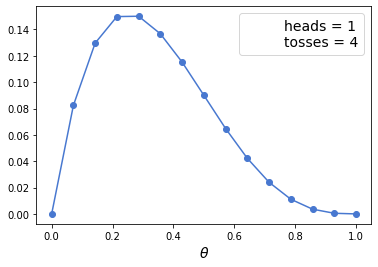

In [4]:
points = 15
h, n = 1, 4
grid, posterior = posterior_grid(points, h, n)
plt.plot(grid, posterior, 'o-')
plt.plot(0, 0, label='heads = {}\ntosses = {}'.format(h, n), alpha=0)
plt.xlabel(r'$\theta$', fontsize=14)
plt.legend(loc=0, fontsize=14)
plt.savefig('B04958_02_01.png', dpi=300, figsize=(5.5, 5.5));

### Quadratic method

The quadratic approximation, also known as the Laplace method or the normal
approximation, consists of approximating the posterior with a Gaussian distribution.  
This method often works because in general the region close to the mode of the
posterior distribution is more or less normal, and in fact in many cases is actually a
Gaussian distribution.   
This method consists of two steps.   
First, find the mode of the posterior distribution.   
This can be done using optimization methods; that is, methods
to find the maximum or minimum of a function, and there are many off-the-shelf
methods for this purpose.  
This will be the mean of the approximating Gaussian.
Then we can estimate the curvature of the function near the mode.  
Based on this curvature, the standard deviation of the approximating Gaussian can be computed. 

### Variational methods

Most of modern Bayesian statistics is done using Markovian methods (see the next
section), but for some problems those methods can be too slow and they do not
necessarily parallelize well.  
The naive approach is to simply run n chains in parallel
and then combine the results, but for many problems this is not a really good
solution.   
Finding effective ways of parallelizing them is an active research area.  
Variational methods could be a better choice for large datasets (think big data)
and/or for likelihoods that are too expensive to compute.   
In addition, these
methods are useful for quick approximations to the posterior and as starting points
for MCMC methods.  

The general idea of variational methods is to approximate the posterior with a
simpler distribution; this may sound similar to the Laplace approximation, but the
similarities vanish when we check the details of the method.   
The main drawback
of variational methods is that we must come up with a specific algorithm for each
model, so it is not really a universal inference engine, but a model-specific one.  
Of course, lots of people have tried to automatize variational methods. A recently
proposed method is the automatic differentiation variational inference (ADVI)
(see http://arxiv.org/abs/1603.00788).   
ADVI is already implemented on PyMC3

## MCMC
To understand what
MCMC methods are we are going to split the method into the two MC parts, the
Monte Carlo part and the Markov Chain part.

## Monte Carlo

Monte Carlo methods are a very broad family of algorithms that use random sampling to compute or simulate a given process.

Monte Carlo is a very famous casino located in the Principality of Monaco.
One of the developers of the Monte Carlo method, Stanislaw Ulam, had an uncle who used to gamble there.
The key idea Stan had was that while many problems are difficult to solve or even formulate in an exact way, they can be effectively studied by taking samples from them, or by simulating them.
In fact, the motivation was to answer questions about the probability of getting a particular hand in a solitary game.
One way to solve this problem was to follow the analytical combinatorial problem.
Another way, Stan argued, was to play several games of solitaire and just count how many of the hands we play match the particular hand we are interested in! Maybe this sounds obvious, or at least pretty reasonable; for example, you may have used re-sampling methods to solve your statistical problems.
But remember this mental experiment was performed about 70 years ago, a time when the first practical computers began to be developed.
The first application of the method was to solve a problem of nuclear physics, a problem really hard to tackle using the conventional tools at that time.
Nowadays, even personal computers are powerful enough to solve many interesting problems using the Monte Carlo approach and hence these methods are applied to a wide variety of problems in science, engineering, industry, arts, and so on.

A classic  example of using a Monte Carlo method to compute a quantity
of interest is the numerical estimation of $\pi$.   
In practice there are better methods for
this particular computation, but its pedagocial value still remains.   
We can estimate
the value of $\pi$ with the following procedure:  
1. Throw $N$ points at random into a square of side $2R$.
2. Draw a circle of radius $R$ inscribed in the square and count the number of
points that are **inside** that circle.
3. Estimate $\hat{\pi}$ as the ratio  $\frac{N×inside}{4}$  
A couple of notes: We know a point is inside a circle if the following relation is true:
$$\sqrt{x^2 + y^2} ≤ R$$

The area of the square is $(2R)^2$ and the area of the circle is ${\pi}R^2$.   
Thus we
know that the ratio of the area of the square to the area of the circle is $\frac{4}{\pi}$, and the area
of the circle and squares are proportional to the number of points inside the circle
and the total $N$ points, respectively.

Using a few lines of Python we can run this simple Monte Carlo simulation and
compute $\pi$ and also the relative error of our estimate compared to the true
value of $\pi$ :

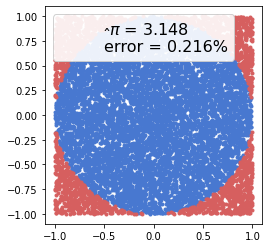

In [5]:
N = 10000

x, y = np.random.uniform(-1, 1, size=(2, N))
inside = (x**2 + y**2)  <= 1
pi = inside.sum()*4/N
error = abs((pi - np.pi)/pi)* 100

outside = np.invert(inside)

plt.plot(x[inside], y[inside], 'b.')
plt.plot(x[outside], y[outside], 'r.')
plt.plot(0, 0, label='$\hat \pi$ = {:4.3f}\nerror = {:4.3f}%'.format(pi, error), alpha=0)
plt.axis('square')
plt.legend(frameon=True, framealpha=0.9, fontsize=16);
plt.savefig('B04958_02_02.png', dpi=300, figsize=(5.5, 5.5))

## Markov chain
A Markov chain is a mathematical object consisting of a sequence of states and a set
of probabilities describing the transitions among those states.   
A chain is Markovian
if the probability of moving to other states depends only on the current state.  
Given such a chain, we can perform a random walk by choosing a starting point
and moving to other states following the transition probabilities.   
If we somehow
find a Markov chain with transitions proportional to the distribution we want to
sample from (the posterior distribution in Bayesian analysis), sampling becomes
just a matter of moving between states in this chain.   
So, how do we find this chain if we do not know the posterior in the first place?   
Well, there is something known as **detailed balance condition**.  
Intuitively, this condition says that we should move in
a reversible way (a reversible process is a common approximation in physics). That
is, the probability of being in state i and moving to state j should be the same as the
probability of being in state j and moving towards state i.

In summary, all this means that if we manage to create a Markov Chain satisfying
detailed balance we can sample from that chain with the guarantee that we will get
samples from the correct distribution.   
This is a truly remarkable result!   
The most
popular method that guarantees detailed balance is the Metropolis-Hasting algorithm.

## Metropolis

In [6]:
def metropolis(func, steps=10000):
    """A very simple Metropolis implementation"""
    samples = np.zeros(steps)
    old_x = func.mean()
    old_prob = func.pdf(old_x)

    for i in range(steps):
        new_x = old_x + np.random.normal(0, 1)
        new_prob = func.pdf(new_x)
        acceptance = new_prob/old_prob
        if acceptance >= np.random.random():
            samples[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else:
            samples[i] = old_x
    return samples

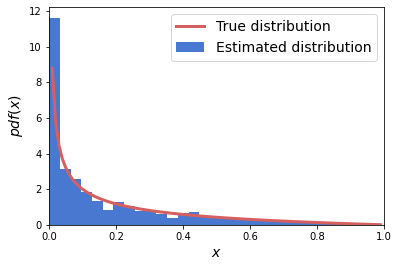

In [7]:
np.random.seed(345)
func = stats.beta(0.4, 2)
samples = metropolis(func=func)
x = np.linspace(0.01, .99, 100)
y = func.pdf(x)
plt.xlim(0, 1)
plt.plot(x, y, 'r-', lw=3, label='True distribution')
plt.hist(samples, bins=30, density=True, stacked=True, label='Estimated distribution')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$pdf(x)$', fontsize=14)
plt.legend(fontsize=14)
plt.savefig('B04958_02_03.png', dpi=300, figsize=(5.5, 5.5));

# PyMC3 introduction 

PyMC3 is a Python library for probabilistic programming. PyMC3 provides a very simple and intuitive syntax that is easy to read and that is close to the syntax used in the statistical literature to describe probabilistic models. PyMC3 is written using Python, where the computationally demanding parts are written using NumPy and Theano. Theano is a Python library originally developed for deep learning that allows us to define, optimize, and evaluate mathematical expressions involving multidimensional arrays efficiently. The main reason PyMC3 uses Theano is because some of the sampling methods, like NUTS, need gradients to be computed and Theano knows how to do automatic differentiation. Also, Theano compiles Python code to C code, and hence PyMC3 is really fast. This is all the information about Theano we need to have to use PyMC3. If you still want to learn more about it start reading the official Theano tutorial at http://deeplearning.net/software/theano/tutorial/index.html#tutorial. 

## Coin-flipping, the computational approach 

Let's revisit the coin-flipping problem, but this time using PyMC3. The first requirement is to get our data. We will use the same synthetic data as before. Since we are generating the data we know the value of $\theta$, <span style="font-family: Courier New; font-size: 1.15em;">theta_real</span> in the following code. Of course, for a real dataset we would not have this knowledge and in fact this is what we want to estimate:

In [8]:
np.random.seed(123)
n_experiments = 4
theta_real = 0.35  # unkwon value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=n_experiments)
data

array([1, 0, 0, 0])

### Model specification 

Now that we have the data, we need to specify the model. Remember this is done by specifying the likelihood and the prior using probability distributions. As the likelihood, we will use the binomial distribution with parameter $n=1$ and $p=\theta$, and for the prior a beta with $\alpha = \beta =1$. This beta distribution is equivalent to a uniform distribution in the interval [0,1]. We can write the model using mathematical notation as follows: 

$\theta \sim Beta(\alpha=1, \beta=1)$  
$y \sim Bin(n=1, p=\theta)$  


This statistical model has an almost one-to-one translation to the PyMC3 syntax.   
* The first line of the code creates a container for our first model, PyMC3 uses the <span style="font-family: Courier New; font-size: 1.15em;">with</span> statement to indicate that everything inside the with block points to the same model.   
You can think of this as syntactic sugar to ease model specification. Imaginatively, our model is called <span style="font-family: Courier New; font-size: 1.15em;">our_first_model</span>. 
* The second line specifies the prior, and, as you can see, the syntax follows the mathematical notation closely.   
We call the random variable <span style="font-family: Courier New; font-size: 1.15em;">theta</span>.   
Please note that this name matches the first argument of the PyMC3 <span style="font-family: Courier New; font-size: 1.15em;">Beta</span> function; having both names the same is a good practice to avoid confusion.   
Then we will use the name of the variable to extract information from the sampled posterior.   
The variable <span style="font-family: Courier New; font-size: 1.15em;">theta</span> is a stochastic variable; we can think of this variable as the rule to generate numbers from a given distribution (a beta distribution in this case) and not actual numbers.   
* The third line specifies the likelihood following the same syntax as for the prior except that we pass the data using the <span style="font-family: Courier New; font-size: 1.15em;">observed</span> argument.   
This is the way in which we tell PyMC3 that this is the likelihood.   
The data can be a Python list, a NumPy array or a Pandas DataFrame.   
That's all it takes to specify our model!


In [9]:
with pm.Model() as our_first_model:
    # a priori
    theta = pm.Beta('theta', alpha=1, beta=1)
    # likelihood
    y = pm.Bernoulli('y', p=theta, observed=data)
    
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step)    

100%|██████████| 1500/1500 [00:00<00:00, 6407.40it/s]


In [10]:
import arviz as az

### Pushing the inference button 

For this problem the posterior can be computed analytically and we can also take samples form the posterior using PyMC3 with just a few lines.   
 
* The fourth line is used to define the sampling method.   
Here we are using Metropolis-Hastings, simply called Metropolis.  
PyMC3 allows us to assign different samplers to different random variables; for now we have a model with only one parameter, but later we will have more variables.   
Alternatively, we can even omit this line and PyMC3 will assign samplers automatically to each variable based on properties of those variables.   
For example, NUTS works only for continuous variables and hence cannot be used with a discrete one, Metropolis can deal with discrete variables, and other types of variables have specially dedicated samplers.   
In general we should let PyMC3 choose the sampler for us.   
* The last line performs the inference.   
The first argument is the number of samples we want, and the second and third arguments are the sampling method and the starting point. 

### Diagnosing the sampling process 

Since we are approximating the posterior with a finite number of samples, the first thing we need to do is to check if we have a reasonable approximation. There are several tests we can run, some are visual and some quantitative. These tests try to find problems with our samples but they cannot prove we have the correct distribution; they can only provide evidence that the sample seems reasonable. If we find problems with the sample, the solutions are: 
* Increase the number of samples.
* Remove a number of samples from the beginning of the trace. This is know as burn-in. MCMC methods often take some time until we start getting samples from the target distribution. The burn-in will not be necessary for an infinite sample, as it is not part of the Markovian theory. Instead, removing the first samples is an ad hoc trick to get better results given that we are getting a finite sample. Remember we should not get confused by mixing mathematical objects with the approximation of those objects. Spheres, Gaussian, Markov chains, and all the mathematical objects live only in the platonic world of the ideas, not in our imperfect but real world. 
* Re-parametrize the model, that is express the model in a different but equivalent way. 
* Transform the data. This can help a lot to get a much more efficient sampling. When transforming the data we should take care to interpret the result in the transformed space or, alternatively, revert the transformation before interpreting the results. 

### Convergence 

Generally, the first task we will perform is to check what the results look like.  The traceplot function is ideally suited to this task:

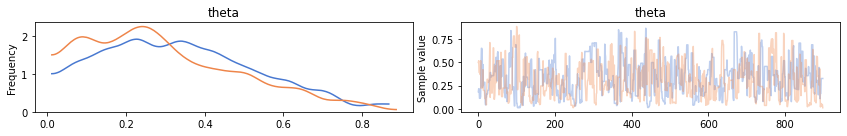

In [11]:
burnin = 100  
chain = trace[burnin:]
pm.traceplot(chain, varnames=['theta'])
plt.savefig('B04958_02_04.png', dpi=300, figsize=(5.5, 5.5))

We get two plots for each unobserved variable. On the left, we get a kernel density estimation (KDE) plot; this is like the smoothed version of a histogram. On the right, we get the individual sampled values at each step during the sampling. Notice that the read line is indicating the value of the variable <span style="font-family: Courier New; font-size: 1.15em;">theta_real</span>.

What do we need to look at when we see these plots?  
Well, KDE plots should look like smooth curves.   
Often, as the number of data increases, the distribution of each parameter will tend to become Gaussian-like; this is due to the law of the large numbers.   
Of course, this is not always true.   
The plot on the right should look like white noise; we are looking for good mixing.   
We should not see any recognizable pattern, we should not see a curve going up or down, instead we want a curve meandering around a single value.   
For multimodal distributions or discrete distributions we expect the curve to not spend too much time in a value or region before moving to other regions, we want to see sampled values moving freely among these regions.   
We should also expect to see a stable auto-similar trace, that is, a trace that at different points looks more or less the same; for example, the first 10% (or so) should look similar to other portions in the trace like the last 50% or 10%.   
Once again, we do not want patterns; instead we expect something noisy.   
See the following figure for some examples of traces with good mixing (on the right) and bad mixing (on the left):


<img src="pic2\fig_2_1.png" width="700">

If the first part of the trace looks different than the others this is an indication of the need for burnin. If we see a lack of auto-similarity in other parts or we see some pattern this is an indication for more steps, or the need to use a different sampler or a different parametrization. For difficult models, we may apply a combination of all these strategies.

PyMC3 allows us to run a model several times in parallel and thus get a parallel chain for the same parameter. This is specified with the argument njobs in the sample function. Using traceplot, we plot all the chains for the same parameter in the same plot. Since each chain is independent of the others and each chain should be a good sample, all the chain should look similar to each other. Besides checking for convergence, these parallel chains can be used also for inference; instead of discarding the extra chains, we can combine them to increase the sample size.

In [12]:
with our_first_model:
    step = pm.Metropolis()
    multi_trace = pm.sample(1000, step=step)

100%|██████████| 1500/1500 [00:00<00:00, 5352.30it/s]


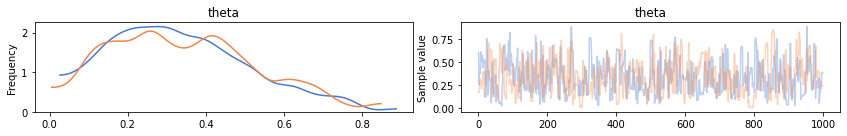

In [13]:
burnin = 0  # no burnin
multi_chain = multi_trace[burnin:]
#pm.traceplot(multi_chain, lines={'theta':theta_real});
pm.traceplot(multi_chain, varnames=['theta'])
plt.savefig('B04958_02_06.png', dpi=300, figsize=(5.5, 5.5))

In [14]:
! pip install arviz



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


A quantitative way to check for convergence is by using the Gelman-Rubin test. The idea of this test is to compare the variance between chains with the variance within chains, so of course we need more than one chain for this test to work. Ideally, we should expect a value of $\hat{R} = 1$. As an empirical rule, we will be ok with a value below 1.1; higher values are signaling a lack of convergence:


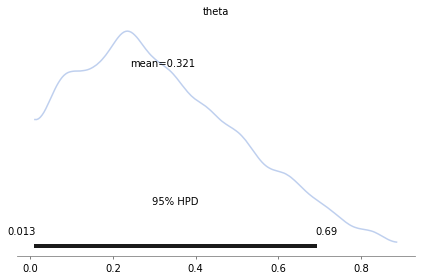

In [18]:
#az.plot_posterior(chain)
pm.plot_posterior(chain, kde_plot=True)

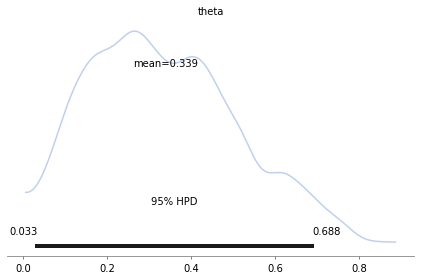

In [21]:
pm.plot_posterior(multi_chain, kde_plot=True)

GridSpec(1, 2, width_ratios=[3, 1])

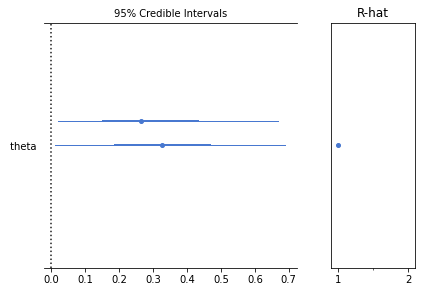

In [24]:
pm.forestplot(chain, varnames=["theta"])

/usr/local/lib/python3.7/dist-packages/pymc3/plots/forestplot.py:177: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  gr_plot.set_xticks((1.0, 1.5, 2.0), ("1", "1.5", "2+"))
/usr/local/lib/python3.7/dist-packages/pymc3/plots/forestplot.py:318: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
/usr/local/lib/python3.7/dist-packages/pymc3/plots/forestplot.py:319: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


GridSpec(1, 2, width_ratios=[3, 1])

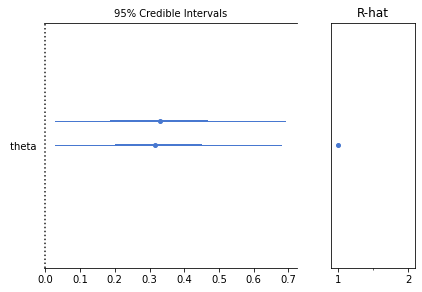

In [23]:
pm.forestplot(multi_chain, varnames=["theta"])

The function <span style="font-family: Courier New; font-size: 1.15em;">summary</span> provides a text-format summary of the posterior. We get the mean, standard deviation, and the HPD intervals:


In [26]:
pm.summary(chain) # hpd_2.5 부터  hpd_97.5  --> 95% Credible Interval 

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,0.320959,0.193681,0.010432,0.012841,0.689547,297.838449,1.008077


In [25]:
pm.summary(multi_chain) # hpd_2.5 부터  hpd_97.5  --> 95% Credible Interval 

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,0.339329,0.180124,0.008856,0.033098,0.68806,358.980617,0.999736


One of the quantities returned is the <span style="font-family: Courier New; font-size: 1.15em;">mc_error</span>. This is an estimation of the error introduced by the sampling method. The estimation takes into account that the samples are not truly independent of each other. The <span style="font-family: Courier New; font-size: 1.15em;">mc_error</span> is the standard error of the means $x$ of $n$ blocks, each block is just a portion of the trace: 
$$MC_{error} = \frac {σ(n)}{\sqrt x} $$

This error should be of course below the precision we want in our results. Since the sampling methods are stochastic, every time we re-run our models the values returned by <span style="font-family: Courier New; font-size: 1.15em;">summary</span>  will be different; nevertheless, they should be similar for different runs. If they are not as similar as we want we may need more samples. 

### Autocorrelation 

An ideal sample will lack autocorrelation, that is, a value at one point should be independent of the values at other points. In practice, samples generated from MCMC methods, especially Metropolis-Hastings, can be autocorrelated. Some models will also lead to more autocorrelated samples due to correlations in the way one parameter depends on the others. PyMC3 comes with a convenient function to plot the autocorrelation:

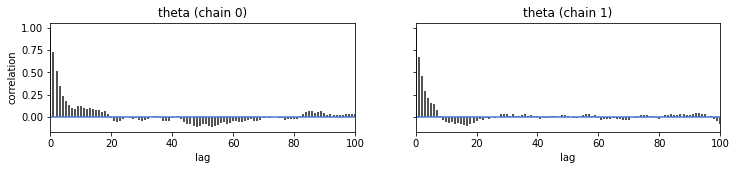

In [27]:
pm.autocorrplot(chain)
plt.savefig('B04958_02_08.png', dpi=300, figsize=(5.5, 5.5))

The plot shows the average correlation of sample values compared to successive points (up to 100 points). Ideally we should see no autocorrelation, in practice; we seek samples that quickly drop to low values of autocorrelation. The more autocorrelated a parameter is, the larger the number of samples we will need to obtain a given precision; that is, autocorrelation has the detrimental effect of lowering the effective number of samples. 

### Effective size 

A sample with autocorrelation has less information than a sample of the same size without autocorrelation. Hence, given a sample of a certain size with a certain degree of autocorrelation we could try to estimate what will be the size of the sample with the same information without autocorrelation. That number will be the effective size of the sample. Ideally both quantities should be the same; the closer the two numbers the more efficient our sampling. The effective size of sample could serve us as a guide. If we want to estimate mean values of a distribution we will need an effective sample of at least 100 samples; if we want to estimate quantities that depend on the tails of distribution, such as the limits of credible intervals, we will need an effective size of 1000 to 10000 samples.

pm.effective_n(multi_chain)['theta']

One way to have more efficient sampling is of course to use a better sampling method. An alternative is to transform the data or re-parametrize the model. Another commonly used option in the literature is to thin a chain. Thinning is just taking every k-esim observation. In Python, we would say taking slices of a chain. Thinning will indeed reduce the autocorrelation, but at the expense of reducing the number of samples. So in practice, it is generally a better idea to just increase the number of samples instead of doing thinning. Nonetheless, thinning can be useful, for example, to reduce storage requirements. When high autocorrelation cannot be avoided, we are obligated to compute long chains, and if our models contain many parameters storage can become problematic. Also we may need to do some post-processing of the posterior such as performing some expensive computation. In such cases having a smaller sample of minimally autocorrelated values could be important. 

All the diagnostic tests we have seen have an empirical component and none of them is definitive. In practice, we run several tests and, if all of them look OK, then we proceed to further analyses. If we detect problems we have to go back and fix them; this is just part of the iterative process of modeling. It is also important to notice that having to run convergence tests is not really part of the Bayesian theory but is about the Bayesian practice, given that we are computing the posterior using numerical methods.

### Summarizing the posterior 

As we have already seen, the result of a Bayesian analysis is a posterior distribution. This contains all the information about our parameters, according to the data and the model. One way to visually summarize the posterior is to use the <span style="font-family: Courier New; font-size: 1.15em;">plot_posterior</span> function that comes with PyMC3. This function accepts a PyMC3 trace or a NumPy array as a main argument. By default, <span style="font-family: Courier New; font-size: 1.15em;">plot_posterior</span> shows a histogram for the credible parameters together with the mean of the distribution and the 94% HPD as a thick black line at the bottom of the plot. Different interval values can be set for the HPD with the argument <span style="font-family: Courier New; font-size: 1.15em;">credible_interval</span>. We are going to refer to this type of plot as Kruschke's plot, since John K. Kruschke introduced this type of plot in his great book Doing Bayesian Data Analysis:

pm.plot_posterior(chain, kde_plot=True)   # 기본 값 credible_interval=0.94 
plt.savefig('B04958_02_09.png', dpi=300, figsize=(5.5, 5.5))

pm.plot_posterior(chain, kde_plot=True, credible_interval=0.5 )   
plt.savefig('B04958_02_09.png', dpi=300, figsize=(5.5, 5.5))

### Posterior-based decisions 

Sometimes describing the posterior is not enough. Sometimes we need to make decisions based on our inferences. We have to reduce a continuous estimation to a dichotomous one: yes or no, contaminated or safe, and so on. Back to our problem, we may need to decide if the coin is fair or not fair. A fair coin is one with a $θ$ value of exactly 0.5. Strictly speaking, the chance of such a result is zero (think of an infinite number of trailing zeros), hence in practice we relax our definition of fairness and we will say a fair coin is one with a value of $θ$ around 0.5. What around exactly means is context-dependent; there is no auto-magic rule that will fit everyone's intentions. Decisions are inherently subjective and our mission is to take the most informed possible decisions according to our goals. Intuitively, one way to take such an informed decision is to compare the HPD to the value of interest, 0.5 in our case. In the preceding figure, we can see that the HPD goes from ~ 0.06 to ~0.71 and hence 0.5 is included in the HPD. According to our posterior, the coin seems to be tail-biased, but we cannot completely rule out the possibility that the coin is fair; maybe if we want a sharper decision we will need to collect more data to reduce the spread of the posterior or maybe we missed some important information that we could use to define a more informative prior.

### ROPE 

One possible option to take a posterior-based decision is to define a Region Of Practical Equivalence (ROPE). This is just an interval around the value of interest; for example, we could say that any value in the interval [0.45, 0.55] will be, for our purposes, practically equivalent to 0.5. Once again the ROPE is context-dependent. So, now we are going to compare the ROPE to the HPD. 

We can define at least  three scenarios: 
* The ROPE does not overlap with the HPD, and hence we can say the coin  is not fair 
* The ROPE contains the entire HPD; we will say the coin is fair 
* The ROPE partially overlaps with HPD; we cannot say the coin is fair  or unfair 

Of course, if we choose a ROPE  to cover the entire interval [0, 1], we will always say we have a fair coin no matter what data we have but probably nobody is going to agree with our ROPE definition. 

The <span style="font-family: Courier New; font-size: 1.15em;">plot_posterior</span> function can be used to plot a ROPE. The ROPE appears as a semi-transparent red and very thick line, together with the overlayed limits  of the ROPE:

pm.plot_posterior(chain, kde_plot=True, credible_interval=0.95, rope=[0.45, .55])
plt.savefig('B04958_02_10.png', dpi=300, figsize=(5.5, 5.5))

We can also pass to <span style="font-family: Courier New; font-size: 1.15em;">plot_posterior</span> a reference value, for example 0.5, that we want to compare with the posterior. We will get a green vertical line and the proportion of the posterior above and below our reference value:

pm.plot_posterior(chain, kde_plot=True, credible_interval=0.95, ref_val=0.5)
plt.savefig('B04958_02_11.png', dpi=300, figsize=(5.5, 5.5))

# likelihood:  Bin( ) vs. Bernoulli( )

동전 던지기 문제에서 observed = data 의 data가 무엇이냐에 따라 pm.binomial( ) 과 pm.bernoulli( ) 중에서 선택한다.

In [28]:
np.random.seed(123)
n_experiments = 4
theta_real = 0.35  # unkwon value in a real experiment
data2 = stats.bernoulli.rvs(p=theta_real, size=n_experiments)
data2

array([1, 0, 0, 0])

In [29]:
data2=data2.sum()
data2

1

In [30]:
with pm.Model() as our_second_model:
    # a priori
    theta2 = pm.Beta('theta2', alpha=1, beta=1)
    # likelihood
    #y = pm.Bernoulli('y', p=theta, observed=data)
    y2 = pm.Binomial('y2',n=n_experiments, p=theta2, observed=data2)
    start2 = pm.find_MAP()
    step2 = pm.Metropolis()
    trace2 = pm.sample(1000, step=step2, start=start2)

/usr/local/lib/python3.7/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1.3863, ||grad|| = 1: 100%|██████████| 6/6 [00:00<00:00, 734.92it/s]
100%|██████████| 1500/1500 [00:00<00:00, 7589.77it/s]


In [31]:
burnin2 = 100  
chain2 = trace2[burnin2:]
#pm.traceplot(chain2, lines={'theta':theta_real});
az.plot_trace(chain2, compact=False, var_names=('theta2'))
plt.savefig('B04958_02_04.png', dpi=300, figsize=(5.5, 5.5))

TypeError: ignored

In [ ]:
pm.summary(chain2) # Binomial

In [ ]:
pm.summary(multi_chain) # Bernoulli

In [ ]:
az.plot_posterior(chain2)
plt.savefig('B04958_02_09.png', dpi=300, figsize=(5.5, 5.5))

In [ ]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was created on a %s computer running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

# 여기까지

In [ ]:
with pm.Model() as our_first_model:
    # a priori
    theta = pm.Beta('theta', alpha=1, beta=1)
    # likelihood
    #y = pm.Bernoulli('y', p=theta, observed=data)
    #y = pm.Binomial('y',n=n_experiments, p=theta, observed=sum(data))
    y = pm.Binomial('y',n=1, p=theta, observed=data)
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step)
    #trace = pm.sample(1000)